<a href="https://colab.research.google.com/github/SJSY126/Quantum/blob/master/Qiskit_pulse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html

In [1]:
!pip install -q qiskit

     |████████████████████████████████| 6.7MB 2.7MB/s 
     |████████████████████████████████| 23.3MB 1.7MB/s 
     |████████████████████████████████| 163kB 44.0MB/s 
     |████████████████████████████████| 184kB 52.4MB/s 
     |████████████████████████████████| 1.9MB 44.3MB/s 
     |████████████████████████████████| 962kB 51.0MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 5.8MB 44.4MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 296kB 46.9MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 26.1MB 1.4MB/s 
     |████████████████████████████████| 583kB 38.5MB/s 
     |████████████████████████████████| 2.7MB 39.4MB/s 


In [5]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
import numpy as np

In [6]:
with open('/content/drive/My Drive/ibmq.txt', 'r') as f:
   ibmq_api_key = f.readline()

IBMQ.save_account(ibmq_api_key)

configrc.store_credentials:WARNING:2020-08-04 12:02:12,382: Credentials already present. Set overwrite=True to overwrite.


In [7]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

open pulseが使えるバックエンドか確認する。
現在使えるバックエンドは`ibmq_armonk`のみ（1qubit）

In [8]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [9]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [10]:
print(backend_config)

PulseBackendConfiguration(_channel_qubit_map={AcquireChannel(0): [0], DriveChannel(0): [0], MeasureChannel(0): [0]}, _control_channels={}, _qubit_channel_map={(0,): [AcquireChannel(0), DriveChannel(0), MeasureChannel(0)]}, acquisition_latency=[], allow_object_storage=True, allow_q_object=True, backend_name='ibmq_armonk', backend_version='1.1.1', basis_gates=['id', 'u1', 'u2', 'u3'], channels={'acquire0': {'operates': {'qubits': [0]}, 'purpose': 'acquire', 'type': 'acquire'}, 'd0': {'operates': {'qubits': [0]}, 'purpose': 'drive', 'type': 'drive'}, 'm0': {'operates': {'qubits': [0]}, 'purpose': 'measure', 'type': 'measure'}}, conditional=False, conditional_latency=[], coupling_map=None, credits_required=True, description='1 qubit device', discriminators=['linear_discriminator', 'quadratic_discriminator'], dt=2.2222222222222221e-10, dtm=2.2222222222222221e-10, dynamic_reprate_enabled=False, gates=[GateConfig(id, [], gate id q { U(0,0,0) q; }, [[0]]), GateConfig(u1, ['lambda'], gate u1(la

In [11]:
backend_defaults = backend.defaults()
print(backend_defaults)

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'x', 'id', 'u1', 'u2', 'u3', 'measure'}
Multi qubit instructions:
)>Qubit Frequencies [GHz]
[4.974452362355146]
Measurement Frequencies [GHz]
[6.993427855] )>


In [12]:


# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.974452362355146 GHz.
The sweep will go from 4.954452362355147 GHz to 4.994452362355147 GHz in steps of 1.0 MHz.


In [13]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [14]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                  # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [15]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [16]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [17]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [18]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

In [19]:
#schedule_frequencies

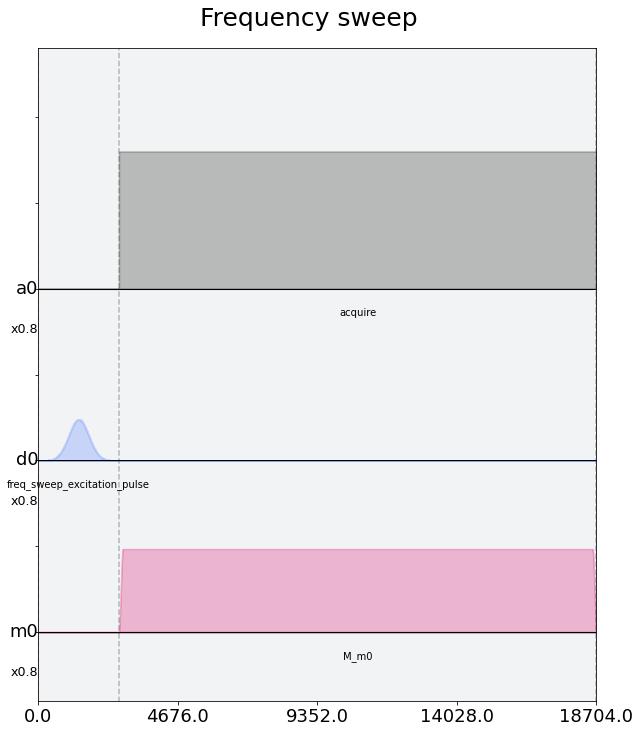

In [20]:
schedule.draw(label=True, scaling=0.8)

In [21]:


num_shots_per_frequency = 8192
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [22]:
job = backend.run(frequency_sweep_program)

In [23]:
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5f294e7659aca10012f63738
Job Status: job has successfully run


In [24]:
job.error_message() 

In [25]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

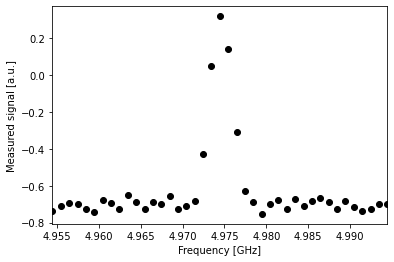

In [26]:


sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

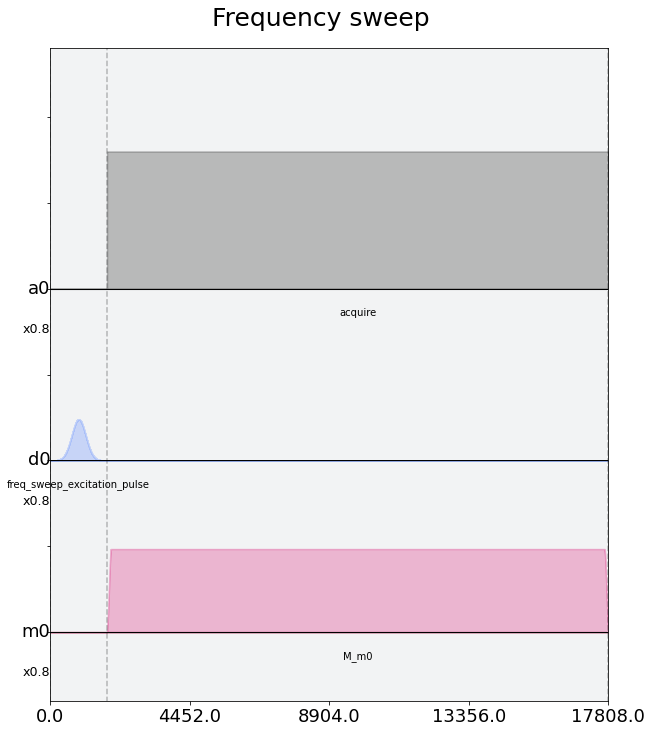

In [27]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.05
drive_samples_us = drive_sigma_us*8

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)      
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)  
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)

schedule += measure << schedule.duration

frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

schedule.draw(label=True, scaling=0.8)

In [29]:
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job = backend.run(frequency_sweep_program)

print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5f2956af159e2600136ca1ac
Job Status: job has successfully run


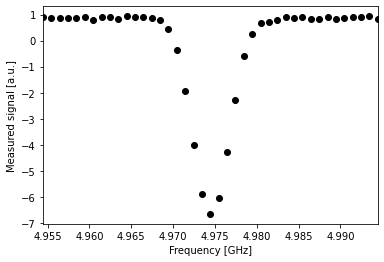

In [31]:
frequency_sweep_results = job.result(timeout=120)
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [32]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [34]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 0.2, 1] # initial parameters for curve_fit
                                )

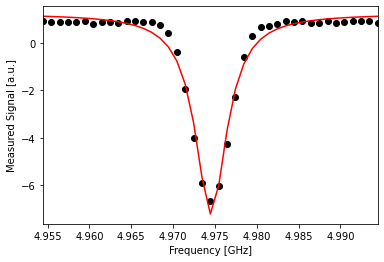

In [35]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [36]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97445 GHz to 4.97453 GHz.
